# Clustering de células de cerebro de ratón mediante procesamiento de datos de RNASeq

El secuenciamiento de células individuales (single-cell RNASeq) es una técnica que identifica y cuantifica la cantidad de ARN, permitiendo así conocer el nivel de expresión de cada gen que compone el genoma de la muestra (los primeros minutos de [iBiology - RNA Sequencing](https://youtu.be/k9VFNLLQP8c?t=91) ejemplifican la aplicación de esta tecnología). En el presente notebook, buscamos implementar un algoritmo de clustering que permita identificar qué tipos de células componen un tejido de glioblastoma proveniente de ratón.

In [30]:
# Lectura de archivos .h5ad
!pip -q install scanpy

Utilizaremos la librería `Scanpy` para el preprocesamiento de datos (documentación [aquí](https://scanpy.readthedocs.io/en/stable/)). El clustering se realizará utilizando spatial clustering mediante `sklearn`.

In [31]:
import pandas as pd
import numpy as np
import scanpy as scp
import matplotlib.pyplot as plt

Obtuvimos la base de datos del consorcio [Tabula Muris](https://www.nature.com/articles/s41586-018-0590-4), quienes realizaron en 2018 un compendio de datos de RNASeq del organismo *Mus musculus* (i.e ratón de laboratorio). Esta base de datos incluye el perfil de expresión génica de ~100,000 células proveniente de 20 órganos y tejidos. Mayor información en https://tabula-muris.ds.czbiohub.org/

In [32]:
!git clone 'https://github.com/frank-britto/grupo06.git'

Cloning into 'grupo06'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 44 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), 25.58 MiB | 7.30 MiB/s, done.


In [33]:
%cd /content/grupo06/challenge_05

/content/grupo06/challenge_05


In [34]:
!unzip 'data.zip'

Archive:  data.zip
replace data/glioblastoma_normalized.h5ad? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/glioblastoma_normalized.h5ad  


In [35]:
glioblastoma = scp.read_h5ad('/content/grupo06/challenge_05/data/glioblastoma_normalized.h5ad')
print(glioblastoma)

AnnData object with n_obs × n_vars = 1651 × 6852
    obs: 'disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts'
    uns: 'pca', 'plate_id_colors'
    obsm: 'X_pca'
    varm: 'PCs'


Al cargar el archivo, obtenemos un objeto de tipo `AnnData`, el cuál presenta la siguiente arquitectura

![](http://falexwolf.de/img/scanpy/anndata.svg)

## Análisis exploratorio de datos

### Matriz de observaciones

La matriz de observaciones contiene información sobre el tipo de célula, si es una neoplasia, y datos experimentales adicionales.

In [36]:
glioblastoma.obs.head()

,disease_state,plate_id,tissue,patient_id,cell_type,neoplastic_state,diagnosis,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,n_counts,n_genes
index,,,,,,,,,,,,,,,,,
GSM2243439,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1341,7.201916,159262.312500,11.978314,65.554424,76.898016,89.034835,98.116145,159262.312500,1341
GSM2243444,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1456,7.284135,326321.875000,12.695642,77.530281,83.443820,90.526005,98.158822,326321.875000,1456
GSM2243445,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1849,7.522941,196996.859375,12.190948,50.919931,59.767944,70.261123,85.793566,196996.859375,1849
GSM2243452,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1788,7.489412,208278.578125,12.246636,45.863893,56.620505,68.793036,87.116435,208278.578125,1788
GSM2243455,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Oligodendrocyte,neoplastic: Regular,Oligodendrocyte,2377,7.774015,288928.750000,12.573939,53.801413,62.445690,72.430413,87.809547,288928.750000,2377


### Matriz de valores

En la matriz `.X` encontraremos los valores de expresión de cada gen para cada muestra (1651 muestras X 6852 genes)

In [37]:
np.shape(glioblastoma.X)

(1651, 6852)

En la matriz `var` obtendremos el nombre de cada gen (index), entre otros datos.

In [38]:
np.shape(glioblastoma.var)

(6852, 8)

La matriz `.obsm` la utilizaremos luego para guardar los componentes del proceso de reducción de dimensionalidad.

### Reducción de dimensionalidad

Para visualizar la información, buscaremos replicar la representación esquemática que utilizan los autores del dataset en su artículo, pero enfocándonos solo en el tejido del cerebro. Para realizar dicha visualización, la documentación de `Scanpy` nos remite a utilizar [UMAP](https://arxiv.org/abs/1802.03426) como estrategia de reducción de dimensionalidad, en vez de PCA o t-SNE. Su aplicación para reducir la dimensionalidad de bases de datos genómicas ya ha sido demostrada en el estado del arte ([Dorrity et al, 2020](https://www.nature.com/articles/s41467-020-15351-4)).
<div>
<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41586-018-0590-4/MediaObjects/41586_2018_590_Fig2_HTML.png?as=webp" width="500"/>
</div>



Implementamos PCA de forma exploratoria.

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


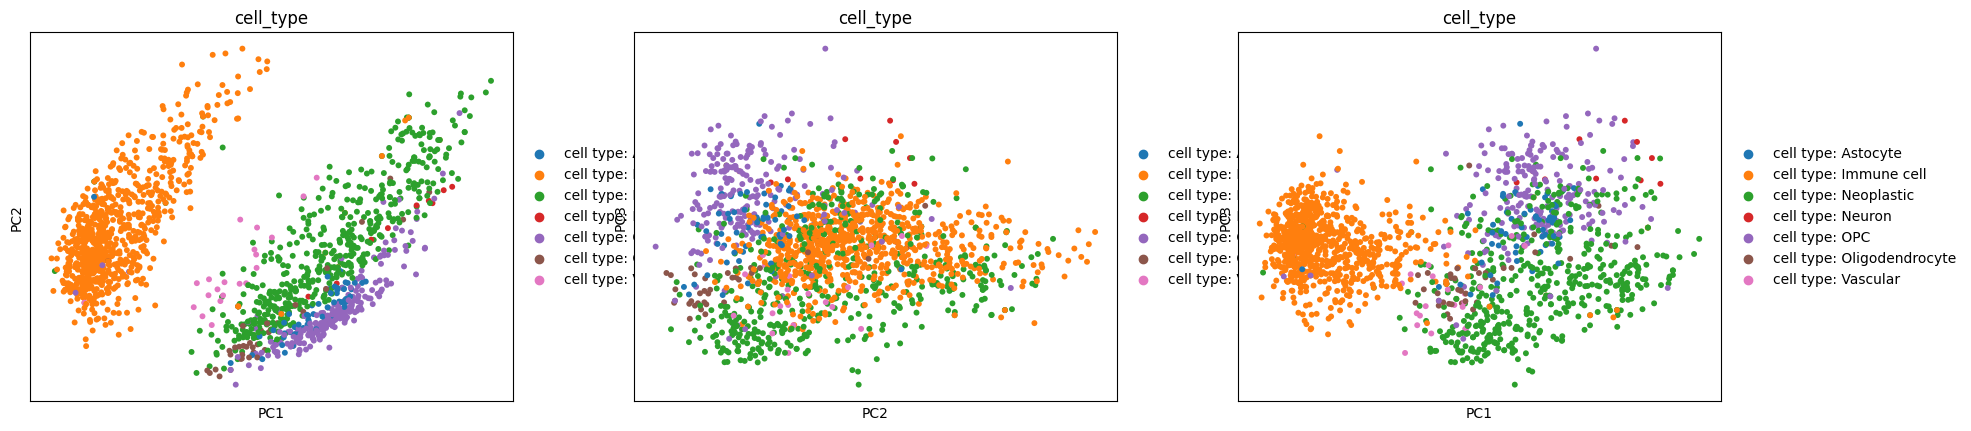

In [39]:
scp.pl.pca(glioblastoma, components = ['1,2', '2,3', '1,3'],
           color = 'cell_type')

Observamos que no es posible resolver la distinción entre clases, por lo que optará, como se mencionó anteriormente, por la técnica UMAP.

In [40]:
#help(scp.tl.umap)

In [41]:
# Calculamos los nearest-neighbors (https://pair-code.github.io/understanding-umap/)
scp.pp.neighbors(glioblastoma)
scp.tl.umap(glioblastoma, min_dist = 0.5, spread = 1.0,
            random_state = 42, n_components = 4)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanp

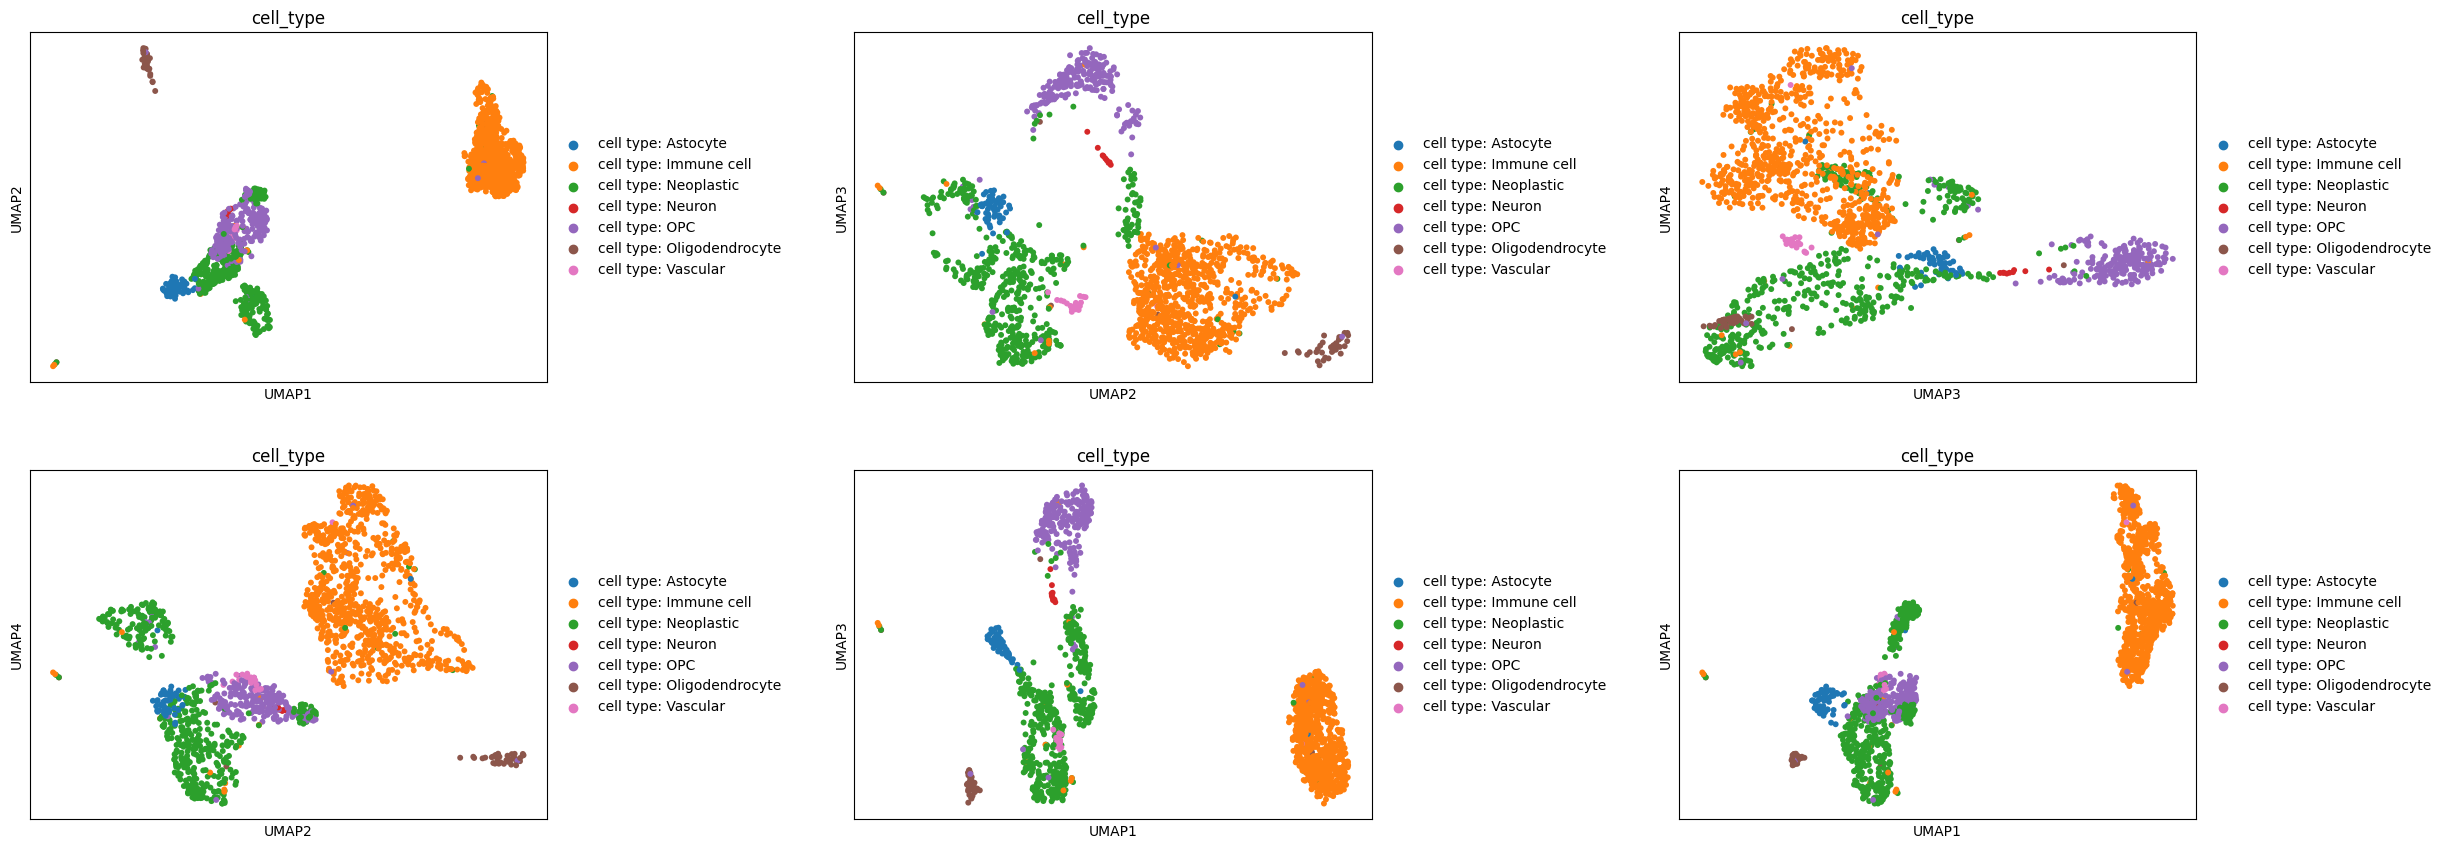

In [42]:
scp.pl.umap(glioblastoma, color = 'cell_type',
            components = ['1,2', '2,3', '3,4', '2,4', '1,3', '1,4'], ncols = 3,
            wspace = 0.45)

La aplicación de UMAP permitió reducir la dimensionalidad a 4 dimensiones, las cuáles se observan en las imágenes en pares. Utilizaremos como referencia el segundo gráfico de la primera columna, donde se comparan los componentes UMAP2 y UMAP3 ya que se puede evidenciar claramente la distinción entre clases. En las demás representaciones, existen clases que se superponen, lo que dificultaría la evaluación de nuestro algoritmo. En ese sentido, en el presente notebook implementamos un algoritmo de spatial clustering para replicar y diferencias entre los tipos celulares de las muestras de glioblastoma, asumiendo el caso en el que **no existieran las etiquetas de clase**.


## Spatial clustering

In [43]:
np.shape(glioblastoma.obsm['X_umap'])

(1651, 4)

Asumiendo que la data no contiene etiquetas, el algoritmo de spatial clustering tendrá la tarea de identificar los tipos celulares a partir de los 4 componentes de la reducción por UMAP.

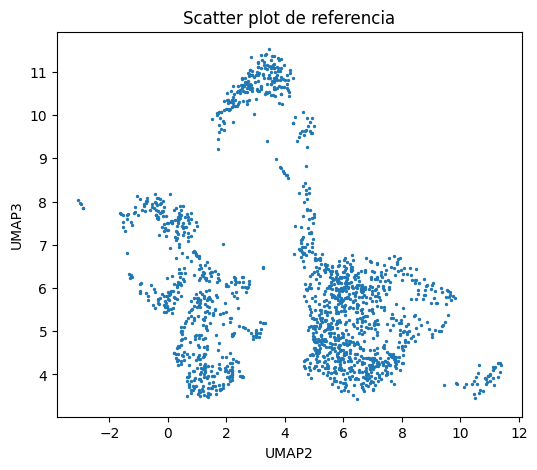

In [44]:
fig = plt.figure(figsize = (6,5))
plt.scatter(glioblastoma.obsm['X_umap'][:,1], glioblastoma.obsm['X_umap'][:,2], s = 2)
plt.xlabel('UMAP2')
plt.ylabel('UMAP3')
plt.title('Scatter plot de referencia')
plt.show()

Implementamos el algoritmo spatial clustering, asumiendo de que ya conocemos el número de clases.

In [45]:
glioblastoma.obs['cell_type'].value_counts()

cell type: Immune cell        814
cell type: Neoplastic         490
cell type: OPC                221
cell type: Astocyte            57
cell type: Oligodendrocyte     39
cell type: Vascular            21
cell type: Neuron               9
Name: cell_type, dtype: int64

Iniciaremos generando la matriz de afinidad calculando los K-nearest neighbors.

In [46]:
from sklearn.cluster import SpectralClustering
model_labels = []
vec = np.array([3,6,10,12])
for nn in vec:
  spectral_clf = SpectralClustering(n_clusters = 7, affinity = 'nearest_neighbors', n_neighbors = nn, n_jobs = 2)
  model_labels.append(spectral_clf.fit_predict(glioblastoma.obsm['X_umap']))

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


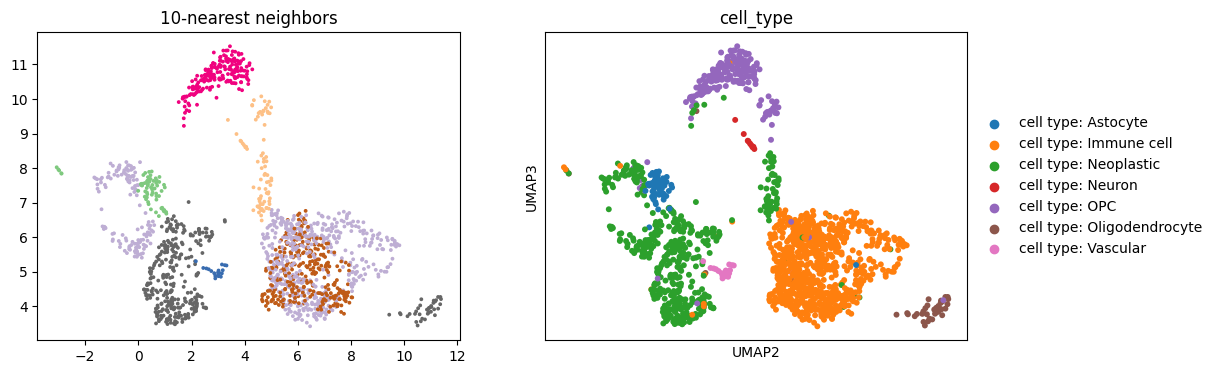

In [47]:
fig,axs = plt.subplots(1, 2, figsize = (12,4))

i = 2 #@param {type:"slider", min:0, max:3, step:1}

axs[0].scatter(glioblastoma.obsm['X_umap'][:,1], glioblastoma.obsm['X_umap'][:,2],
            c = model_labels[i], cmap = 'Accent', s = 3)
axs[0].set_title(f'{vec[i]}-nearest neighbors')
scp.pl.umap(glioblastoma, color = 'cell_type',
              components = ['2,3'],
              wspace = 0.45, ax = axs[1])
plt.show()

Observamos que el mejor desempeño del algoritmo (i.e similitud con los clusters reales) se obtiene para $k = 10$. Sin embargo, este implica la capacidad de reconocer correctamente 2 de las 7 clases: células vasculares y oligodendrocitos; y con cierto nivel de error, las células progenitoras de oligodendrocitos (OPC). Buscando optimizar estos resultados, se cambiará la matriz de afinidad a un kernel rbf.

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


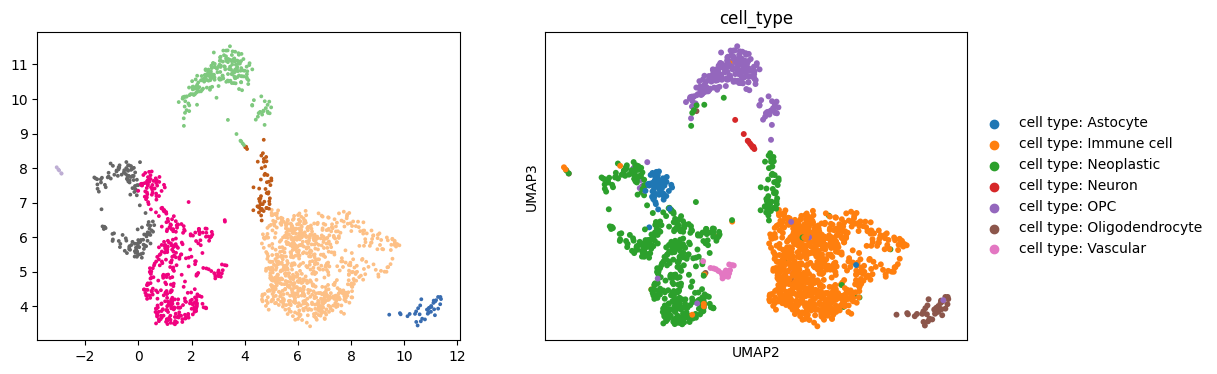

In [48]:
spectral_clf = SpectralClustering(n_clusters = 7, affinity = 'rbf', gamma = 1.1, n_jobs = 2, assign_labels = 'kmeans',
                                  degree = 3)
labels = spectral_clf.fit_predict(glioblastoma.obsm['X_umap'])
fig,axs = plt.subplots(1, 2, figsize = (12,4))
axs[0].scatter(glioblastoma.obsm['X_umap'][:,1], glioblastoma.obsm['X_umap'][:,2],
          c = labels, cmap = 'Accent', s = 3)
scp.pl.umap(glioblastoma, color = 'cell_type',
            components = ['2,3'],
            wspace = 0.45, ax = axs[1])
plt.show()

### Evaluación de desempeño

En este caso, conocemos el "ground truth" de las variables (i.e la etiqueta real), por lo que podemos utilizar las métricas de desempeño de `sklearn`.

In [49]:
# Clusters predecidos con rbf
glioblastoma.obs['spectral_rbf'] = labels
glioblastoma.obs['spectral_rbf'] = glioblastoma.obs['spectral_rbf'].astype(str)

# Clusters predecidos con knn
glioblastoma.obs['spectral_knn'] = model_labels[2]
glioblastoma.obs['spectral_knn'] = glioblastoma.obs['spectral_knn'].astype(str)

In [50]:
# Clusters reales (ground-truth)
glioblastoma.obs['cell_type'].unique()

['cell type: Neoplastic', 'cell type: Oligodendrocyte', 'cell type: Immune cell', 'cell type: Vascular', 'cell type: OPC', 'cell type: Astocyte', 'cell type: Neuron']
Categories (7, object): ['cell type: Astocyte', 'cell type: Immune cell', 'cell type: Neoplastic',
                         'cell type: Neuron', 'cell type: OPC', 'cell type: Oligodendrocyte',
                         'cell type: Vascular']

### Índice de Rand

De acuerdo a la definición de `sklearn.metrics.adjusted_rand_score`,


> El índice de Rand ajustado tendrá un valor próximo a 0.0 si el etiquetado de clases fue aleatorio, independientemente del número de clusters y muestras, y exactamente 1.0 cuando los clusters predecidos y reales son idénticos.



In [51]:
from sklearn.metrics import adjusted_rand_score
rand_index_rbf = adjusted_rand_score(labels_true = glioblastoma.obs['cell_type'],
                                 labels_pred = glioblastoma.obs['spectral_rbf'])
print(f'Índice de Rand para rbf: {rand_index_rbf:.4f}')
rand_index_knn = adjusted_rand_score(labels_true = glioblastoma.obs['cell_type'],
                                 labels_pred = glioblastoma.obs['spectral_knn'])
print(f'Índice de Rand para knn: {rand_index_knn:.4f}')

Índice de Rand para rbf: 0.8007
Índice de Rand para knn: 0.4316


### Completeness score

De acuerdo a la definición de `sklearn.metrics.completeness_score`,


> Un resultado de clustering será "completo" si todos los datos que son miembros de una clase son elementos del mismo cluster



In [52]:
from sklearn.metrics import completeness_score
complete_rbf = completeness_score(labels_true = glioblastoma.obs['cell_type'],
                                 labels_pred = glioblastoma.obs['spectral_rbf'])
print(f'Completeness score para rbf: {complete_rbf:.4f}')
complete_knn = completeness_score(labels_true = glioblastoma.obs['cell_type'],
                                 labels_pred = glioblastoma.obs['spectral_knn'])
print(f'Completeness score para knn: {complete_knn:.4f}')

Completeness score para rbf: 0.6996
Completeness score para knn: 0.5142


### Fowlkes Mallows score

De acuerdo a la definición de `sklearn.metrics.fowlkes_mallows_score`,


> Es la media geométrica entre la precisión y el recall



In [53]:
from sklearn.metrics import fowlkes_mallows_score
mallow_rbf = fowlkes_mallows_score(labels_true = glioblastoma.obs['cell_type'],
                                 labels_pred = glioblastoma.obs['spectral_rbf'])
print(f'Fowlkes Mallows score para rbf: {mallow_rbf:.4f}')
mallow_knn = fowlkes_mallows_score(labels_true = glioblastoma.obs['cell_type'],
                                 labels_pred = glioblastoma.obs['spectral_knn'])
print(f'Fowlkes Mallows score para knn: {mallow_knn:.4f}')

Fowlkes Mallows score para rbf: 0.8685
Fowlkes Mallows score para knn: 0.6054


## Discusión

* Las métricas de desempeño (índice de Rand, completeness score y Fowlkes Mallow score) demuestran que, para esta base de datos representada por sus componentes UMAP, **el algoritmo de spectral clustering con una matriz de afinidad con un kernel rbf genera clusters con mayor similitud a la clase real**. Sin embargo, reconocemos que este tipo de métrica no siempre se encuentra disponible pues no siempre se cuentan con las etiquetas reales ([Tian et al, 2019](https://www.nature.com/articles/s42256-019-0037-0)). 
* El rendimiento del algoritmo de spectral clustering depende directamente de la operación de reducción de dimensionalidad, por lo que aumentar los scores implicaría obtener componentes UMAP más representativos, o bien utilizar otra estrategia
* Las principales desventajas identificadas son que **el usuario debe conocer de antemano el número de clusters**. Además, no es estrictamente reproducible (si corremos el código más de una vez, ciertos puntos son asignados a otra clase adyacente)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


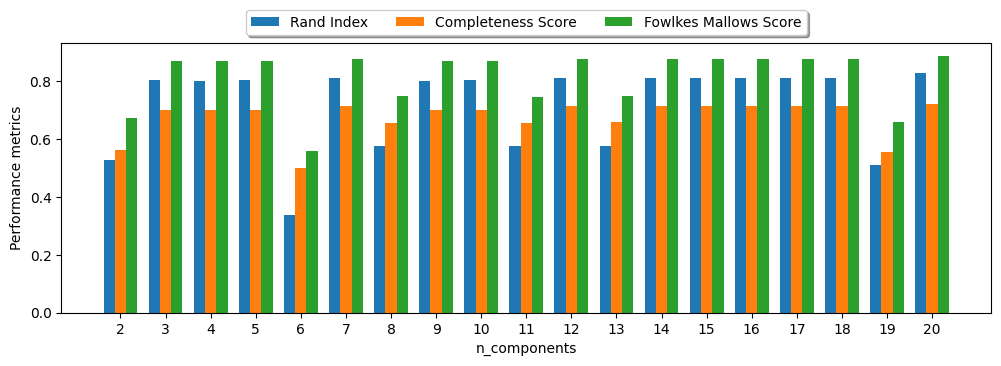

In [54]:
#@title Reducción de dimensionalidad y métricas de desempeño
"""
Análisis complementario N°1: ¿existirá una correlación entre un mayor número de componentes
UMAP y un mejor desempeño?
"""
vec = np.linspace(2,20,19)
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,3.5))
width = np.min(np.diff(vec))/4

# UMAP
fow_mal_score = []
complete_score = []
rand_score = []
for n_comp in vec:
  scp.pp.neighbors(glioblastoma)
  scp.tl.umap(glioblastoma, min_dist = 0.5, spread = 1.0,
              random_state = 42, n_components = int(n_comp))
  spectral_clf = SpectralClustering(n_clusters = 7, affinity = 'rbf', gamma = 1.1, n_jobs = 2, assign_labels = 'kmeans',
                                  degree = 3)
  labels = spectral_clf.fit_predict(glioblastoma.obsm['X_umap'])

  rand_score.append(adjusted_rand_score(labels_true = glioblastoma.obs['cell_type'],
                                 labels_pred = labels))
  complete_score.append(completeness_score(labels_true = glioblastoma.obs['cell_type'],
                                 labels_pred = labels))
  fow_mal_score.append(fowlkes_mallows_score(labels_true = glioblastoma.obs['cell_type'],
                                 labels_pred = labels))

ax.bar(vec-width, rand_score, width, label = 'Rand Index')
ax.bar(vec, complete_score, width, label = 'Completeness Score')
ax.bar(vec+width, fow_mal_score, width, label = 'Fowlkes Mallows Score')

plt.legend()

ax.set_xlabel('n_components')
ax.set_ylabel('Performance metrics')
ax.set_xticks(vec, range(2,21))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
            ncol=3, fancybox=True, shadow=True)
plt.show()